## Modelling on a subset of data

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import joblib

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense,Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

#### Loading data

In [ ]:
low_mem = True

In [ ]:
path = '/content/drive/MyDrive/NEWSsummarization/Dataset/train2.csv'

In [ ]:
data = pd.read_csv(path,usecols=['title','text','summary','compression_bin'])

In [ ]:
data.head()

,title,text,summary,compression_bin
0,The Telescope of the 2030s,"In what they termed “a call to arms,” an organ...","Facing a funding labyrinth, American universit...",high
1,Julie Klausner Happily Channels Restlessness I...,You could say it’s all because of “Cats.” Juli...,"Ms. Klausner, who will be increasingly in the ...",medium
2,Review: ‘My Depression (The Up and Down and Up...,"As a theater artist, the versatile Elizabeth S...",This HBO movie is as whimsical a discussion of...,medium
3,Why Hillary Clinton Wants to Remember Your Bir...,Hillary Rodham Clinton says she always remembe...,The supporter gets a card. The campaign gets a...,medium
4,"A Eulogy for the Long, Intimate Email","When I started college in 1997, I got my first...",Of the many supposed casualties of the Interne...,high


#### Clean data set

In [ ]:
data = data[data['compression_bin']=='medium'][['title','text','summary']]

In [ ]:
data.reset_index(inplace=True)
data.drop(['index'],axis=1,inplace=True)

In [ ]:
data.head()

,title,text,summary
0,Julie Klausner Happily Channels Restlessness I...,You could say it’s all because of “Cats.” Juli...,"Ms. Klausner, who will be increasingly in the ..."
1,Review: ‘My Depression (The Up and Down and Up...,"As a theater artist, the versatile Elizabeth S...",This HBO movie is as whimsical a discussion of...
2,Why Hillary Clinton Wants to Remember Your Bir...,Hillary Rodham Clinton says she always remembe...,The supporter gets a card. The campaign gets a...
3,Fifth Avenue Duplex With a Touch of French Cou...,A spacious duplex co-op on the top residential...,A spacious co-op on the top residential floor ...
4,"Man Charged With Abandoning Daughter, 3, at a ...","Crying out “Daddy, Daddy, Daddy,” the 3-year-o...",The police said Stanley Fredrique bought a tur...


In [ ]:
def clean_text(mess):
  regex = r"[^a-zA-Z0-9\s]"
  mess = mess.lower()
  mess = re.sub('<br /><br />',' ', mess)
  
  mess=re.sub("(\\n)", ' ', mess)
  mess = re.sub(regex,'', mess)  # Remove all none alphanumeric characters
  mess = re.sub('  ',' ',mess)             # remove double white spaces

  return mess

In [ ]:
data['text'] = data['text'].apply(clean_text)
data['summary'] = data['summary'].apply(clean_text)

#### Uniform size

In [ ]:
def get_text_len(x):
  l = len(x.split(' '))
  return l

In [ ]:
data['text_len'] = data['text'].apply(get_text_len)
data['summary_len'] = data['summary'].apply(get_text_len)

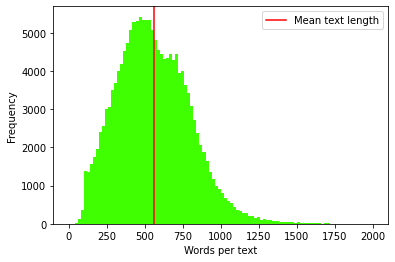

In [ ]:
mean_text_len = np.mean(data['text_len'].values)
plt.hist(data['text_len'].values,bins=100,range=(0,2000),color='#40ff00')
plt.axvline(mean_text_len,color='red',label='Mean text length')
plt.xlabel('Words per text')
plt.ylabel('Frequency')
plt.legend()
plt.show()


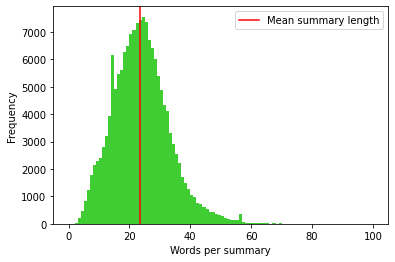

In [ ]:
mean_summary_len = np.mean(data['summary_len'].values)
plt.hist(data['summary_len'].values,bins=100,range=(0,100),color='#40cc33')
plt.axvline(mean_summary_len,color='red',label='Mean summary length')
plt.xlabel('Words per summary')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# concluding from distributions
max_text = 750
max_summary = 40

In [ ]:
# strip lengths 
data_short = data[data['text_len'] <= max_text]
data_short = data_short[data_short['summary_len'] <= max_summary][['text','summary']]

In [ ]:
del data

In [ ]:
data_short.reset_index(inplace=True)
data_short.drop(['index'],axis=1,inplace=True)

#### Add start and end tags

In [ ]:
def add_tags(mess):
  return "<s> "+ mess + " </s>"

In [ ]:
data_short['summary'] = data_short['summary'].apply(add_tags)

In [ ]:
data_short.head()

,text,summary
0,as a theater artist the versatile elizabeth sw...,<s> this hbo movie is as whimsical a discussio...
1,hillary rodham clinton says she always remembe...,<s> the supporter gets a card the campaign get...
2,crying out daddy daddy daddy the 3yearold girl...,<s> the police said stanley fredrique bought a...
3,the oxi pamphlets calling for a no vote still ...,<s> liz alderman describes the mood in greece ...
4,after a steady siege of washington infighting ...,<s> national consensus not family members shou...


#### Train test split

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(data_short['text'].values,data_short['summary'].values,test_size=0.2,random_state=71,shuffle=True)

#### Tokenize

In [ ]:
text_vocab = 100000
sum_vocab  = 100000

In [ ]:
# For input
# create and fit tokenizer
text_tokenizer = Tokenizer(num_words=text_vocab)
text_tokenizer.fit_on_texts(x_train)

In [ ]:
# convert to tokens
x_train_tokens = text_tokenizer.texts_to_sequences(x_train)
x_val_tokens = text_tokenizer.texts_to_sequences(x_val)

In [ ]:
# pad sequences to max_text
x_train_tokens = pad_sequences(x_train_tokens,  maxlen=max_text, padding='post')
x_val_tokens = pad_sequences(x_val_tokens, maxlen=max_text, padding='post')

In [ ]:
# For targets
sum_tokenizer = Tokenizer(num_words=sum_vocab) 
sum_tokenizer.fit_on_texts(y_train)

In [ ]:
y_train_tokens = sum_tokenizer.texts_to_sequences(y_train)
y_val_tokens = sum_tokenizer.texts_to_sequences(y_val)

In [ ]:
# pad sequences to max_summary
y_train_tokens = pad_sequences(y_train_tokens,  maxlen=max_summary, padding='post')
y_val_tokens = pad_sequences(y_val_tokens, maxlen=max_summary, padding='post')

## Incase of low memory store variables uptill now

In [ ]:
if low_mem:
  joblib.dump(x_train_tokens,'x_train')
  joblib.dump(x_val_tokens,'x_val')
  joblib.dump(y_train_tokens,'y_train')
  joblib.dump(y_val_tokens,'y_val')


In [ ]:
if low_mem:
  x_train_tokens = joblib.load('x_train')
  x_val_tokens = joblib.load('x_val')
  y_train_tokens = joblib.load('y_train')
  y_val_tokens = joblib.load('y_val')

## Models

### 2 Encoder LSTM

In [ ]:
latent_dim = 200
embedding_dim = 100

In [ ]:
# Encoder
# input encoder layer
encoder_in = Input(shape=(max_text, ))
# encoder embeddings
encoder_emb = Embedding(text_vocab, embedding_dim, trainable=True)(encoder_in)
# 1 encoder lstm 
encoder_lstm_layer1 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3)
(encoder_output1, state_h1, state_c1) = encoder_lstm_layer1(encoder_emb)
# 2 encoder lstm 
encoder_lstm_layer2 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3)
(encoder_output2, state_h, state_c) = encoder_lstm_layer2(encoder_output1)

In [ ]:
# Decoder
# decoder input
decoder_in = Input(shape=(None, ))
# decoder emmbeddings
decoder_emb_layer = Embedding(sum_vocab, embedding_dim, trainable=True)
decoder_emb = decoder_emb_layer(decoder_in)
# Decoder lstm
decoder_lstm_layer = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm_layer(decoder_emb, initial_state=[state_h, state_c])

In [ ]:
# Dense layer
decoder_dense = TimeDistributed(Dense(sum_vocab, activation='softmax'))
output = decoder_dense(decoder_outputs)

model_2lstm = Model([encoder_in, decoder_in], output)
model_2lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 750)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 750, 100)     10000000    ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 750, 200),   240800      ['embedding_2[0][0]']            
                                 (None, 200),                                               

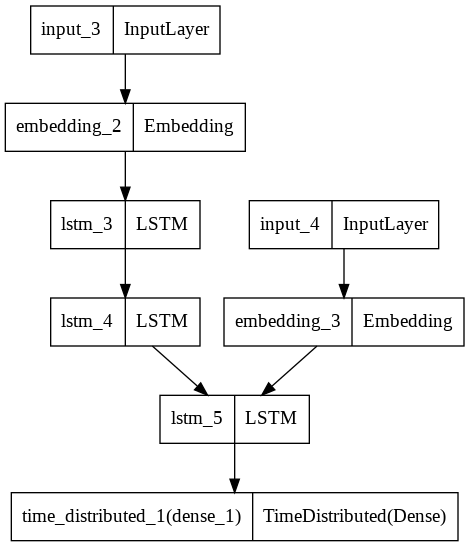

In [ ]:
plot_model(model_2lstm)

In [ ]:
model_2lstm.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

In [ ]:
history = model_2lstm.fit(
    [x_train_tokens, y_train_tokens[:, :-1]],y_train_tokens.reshape(y_train_tokens.shape[0], y_train_tokens.shape[1], 1)[:, 1:],
    epochs=5,
    batch_size=128,
    validation_data=([x_val_tokens, y_val_tokens[:, :-1]],y_val_tokens.reshape(y_val_tokens.shape[0], y_val_tokens.shape[1], 1)[:, 1:]),
    )

Epoch 1/5
793/793 [==============================] - 713s 899ms/step - loss: 4.1424 - val_loss: 3.7735
Epoch 2/5
793/793 [==============================] - 714s 900ms/step - loss: 3.7814 - val_loss: 3.5521
Epoch 3/5
793/793 [==============================] - 714s 901ms/step - loss: 3.5848 - val_loss: 3.4318
Epoch 4/5
793/793 [==============================] - 715s 902ms/step - loss: 3.4473 - val_loss: 3.3502
Epoch 5/5
793/793 [==============================] - 716s 903ms/step - loss: 3.3393 - val_loss: 3.2945


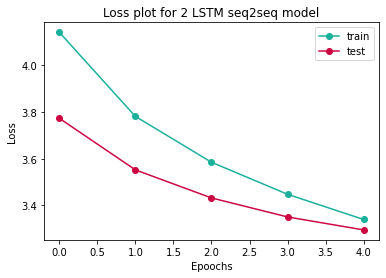

In [ ]:
plt.plot(history.history['loss'],marker='o',color='#1ab09c',label='train')
plt.plot(history.history['val_loss'],marker='o',color='#cc0641', label='test')
plt.xlabel('Epoochs')
plt.ylabel('Loss')
plt.title('Loss plot for 2 LSTM seq2seq model')
plt.legend()
plt.show()

### 3 encoder LSTM

In [ ]:
latent_dim = 200
embedding_dim = 100

In [ ]:
# Encoder
# input encoder layer
encoder_in = Input(shape=(max_text, ),name="Encoder_input")
# encoder embeddings
encoder_emb = Embedding(text_vocab, embedding_dim, trainable=True,name='Encoder_embeddings')(encoder_in)
# 1 encoder lstm 
encoder_lstm_layer1 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Encoder_LSTM1')
(encoder_output1, state_h1, state_c1) = encoder_lstm_layer1(encoder_emb)
# 2 encoder lstm 
encoder_lstm_layer2 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Encoder_LSTM2')
(encoder_output2, state_h2, state_c2) = encoder_lstm_layer2(encoder_output1)
# 3 encoder lstm 
encoder_lstm_layer3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.3,name='Encoder_LSTM3')
encoder_outputs, state_h, state_c= encoder_lstm_layer3(encoder_output2)

In [ ]:
# Decoder
# decoder input
decoder_in = Input(shape=(None, ),name='Decoder_input')
# decoder emmbeddings
decoder_emb_layer = Embedding(sum_vocab, embedding_dim, trainable=True,name='Decoder_embeddings')
decoder_emb = decoder_emb_layer(decoder_in)
# Decoder lstm
decoder_lstm_layer = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Decoder_LSTM1')
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm_layer(decoder_emb, initial_state=[state_h, state_c])

In [ ]:
# Dense layer
decoder_dense = TimeDistributed(Dense(sum_vocab, activation='softmax'),name='Output_dense')
output = decoder_dense(decoder_outputs)

model_3lstm = Model([encoder_in, decoder_in], output)
model_3lstm.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_input (InputLayer)     [(None, 750)]        0           []                               
                                                                                                  
 Encoder_embeddings (Embedding)  (None, 750, 100)    10000000    ['Encoder_input[0][0]']          
                                                                                                  
 Encoder_LSTM1 (LSTM)           [(None, 750, 200),   240800      ['Encoder_embeddings[0][0]']     
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                            

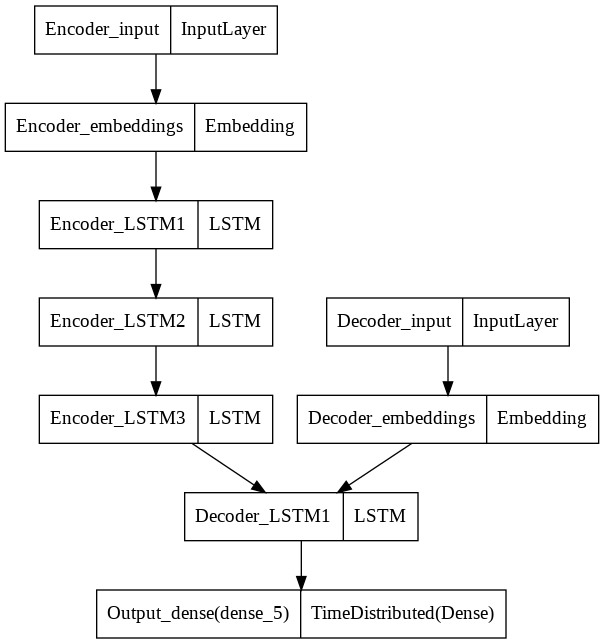

In [ ]:
plot_model(model_3lstm)

In [ ]:
model_3lstm.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy')

In [ ]:
history2 = model_3lstm.fit(
    [x_train_tokens, y_train_tokens[:, :-1]],y_train_tokens.reshape(y_train_tokens.shape[0], y_train_tokens.shape[1], 1)[:, 1:],
    epochs=8,
    batch_size=128,
    validation_data=([x_val_tokens, y_val_tokens[:, :-1]],y_val_tokens.reshape(y_val_tokens.shape[0], y_val_tokens.shape[1], 1)[:, 1:]),
    )

Epoch 1/8
793/793 [==============================] - 823s 974ms/step - loss: 4.3999 - val_loss: 3.6905
Epoch 2/8
793/793 [==============================] - 775s 978ms/step - loss: 3.7874 - val_loss: 3.6276
Epoch 3/8
793/793 [==============================] - 768s 969ms/step - loss: 3.7213 - val_loss: 3.6110
Epoch 4/8
793/793 [==============================] - 765s 965ms/step - loss: 3.6876 - val_loss: 3.6031
Epoch 5/8
793/793 [==============================] - 764s 964ms/step - loss: 3.6635 - val_loss: 3.5987
Epoch 6/8
793/793 [==============================] - 764s 964ms/step - loss: 3.6488 - val_loss: 3.5947
Epoch 7/8
793/793 [==============================] - 763s 962ms/step - loss: 3.6367 - val_loss: 3.5937
Epoch 8/8
793/793 [==============================] - 761s 960ms/step - loss: 3.6283 - val_loss: 3.5911


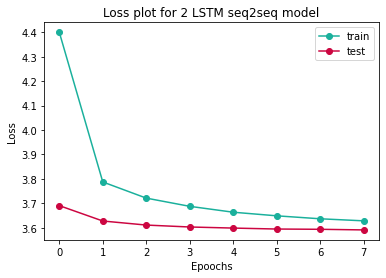

In [ ]:
plt.plot(history2.history['loss'],marker='o',color='#1ab09c',label='train')
plt.plot(history2.history['val_loss'],marker='o',color='#cc0641', label='test')
plt.xlabel('Epoochs')
plt.ylabel('Loss')
plt.title('Loss plot for 2 LSTM seq2seq model')
plt.legend()
plt.show()

### Seq2Seq + attention

In [ ]:
latent_dim = 100
embedding_dim = 100

In [ ]:
# Encoder
# input encoder layer
encoder_in = Input(shape=(max_text, ),name="Encoder_input")
# encoder embeddings
encoder_emb = Embedding(text_vocab, embedding_dim, trainable=True,name='Encoder_embeddings')(encoder_in)
# 1 encoder lstm 
encoder_lstm_layer1 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Encoder_LSTM1')
(encoder_output1, state_h1, state_c1) = encoder_lstm_layer1(encoder_emb)
# 2 encoder lstm 
encoder_lstm_layer2 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Encoder_LSTM2')
(encoder_output2, state_h2, state_c2) = encoder_lstm_layer2(encoder_output1)
# 3 encoder lstm 
encoder_lstm_layer3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.3,name='Encoder_LSTM3')
encoder_outputs, state_h, state_c= encoder_lstm_layer3(encoder_output2)

In [ ]:
# Decoder
# decoder input
decoder_in = Input(shape=(None, ),name='Decoder_input')
# decoder emmbeddings
decoder_emb_layer = Embedding(sum_vocab, embedding_dim, trainable=True,name='Decoder_embeddings')
decoder_emb = decoder_emb_layer(decoder_in)
# Decoder lstm
decoder_lstm_layer = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.3,name='Decoder_LSTM1')
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm_layer(decoder_emb, initial_state=[state_h, state_c])

attention_result, attention_weights = Attention()([encoder_outputs, decoder_outputs])